In [10]:
import os
import torch
from torch.utils.data import DataLoader
from dataset.data_preparation import download, split_dataset
from dataset.super_resolution_dataset import SuperResolutionDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from numpy import genfromtxt
import seaborn as sns
import numpy as np
from SRM.network import SuperResolution
sns.set_style("darkgrid")
sns.set_context("talk")

In [11]:
torch.manual_seed(777)
transform = transforms.Compose([
        transforms.ToTensor()
    ])
download("./data", "airplanes")
root_dir = 'data/airplanes'
dataset = SuperResolutionDataset(root_dir=root_dir, transform=transform)
dataset_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Dataset airplanes already exists.


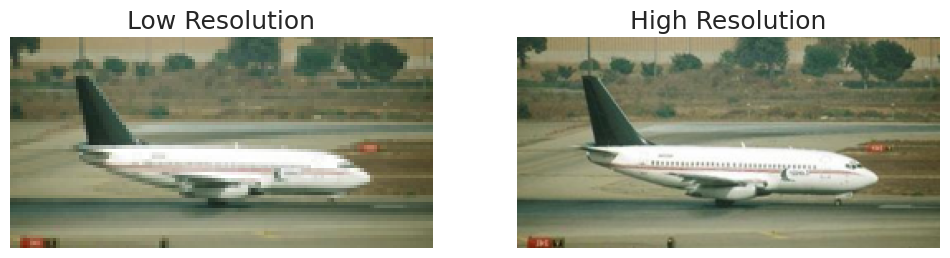

In [12]:
low_res, high_res = next(iter(dataset_dataloader))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(low_res[0].permute(1, 2, 0))
ax[0].set_title("Low Resolution")
ax[0].axis('off')

ax[1].imshow(high_res[0].permute(1, 2, 0))
ax[1].set_title("High Resolution")
ax[1].axis('off')

plt.show()

In [13]:
sizes = {
    "train":0.5,
    "validation":0.3,
    "test":0.2
}
_ , _, test = split_dataset(dataset,sizes)

test_dataloader = DataLoader(test, batch_size=16, shuffle=True)

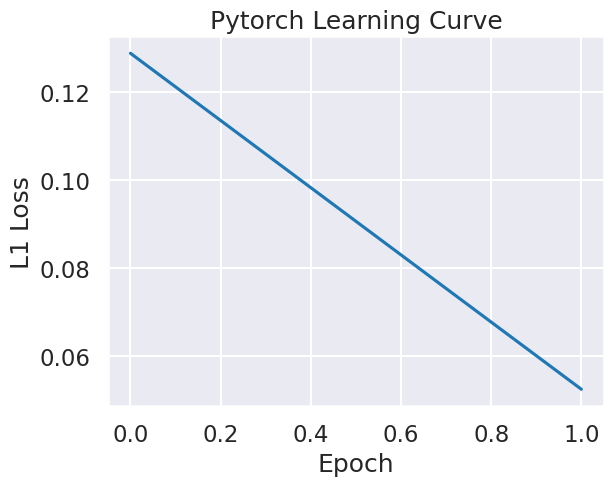

In [14]:
loss_filename = 'training_loss/L1_202408041723.csv'
losses = genfromtxt(loss_filename, delimiter=',')
sns.lineplot(x=np.arange(len(losses)), y=losses)
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.title('Pytorch Learning Curve')
plt.show()

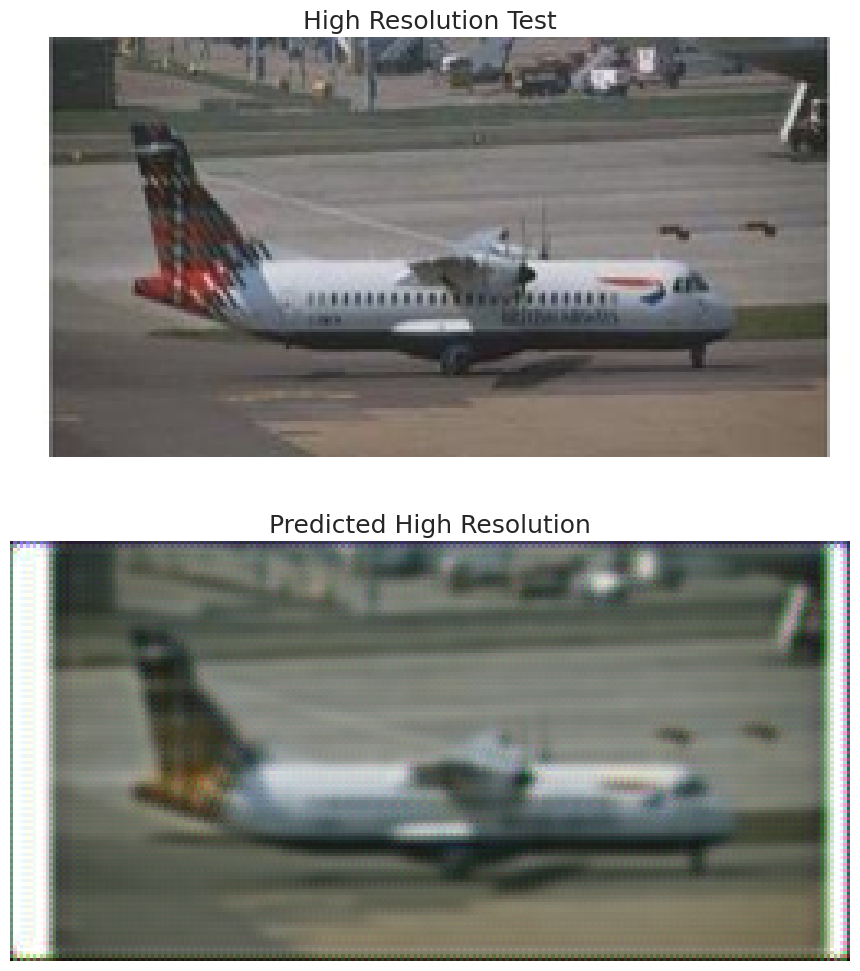

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_filename = "checkpoint/SR_c64_rb16_e2_202408041723.pth"
test_SRN = SuperResolution(64,16)
test_SRN = test_SRN.to(device)

checkpoint_path = model_filename
test_SRN.load_state_dict(torch.load(checkpoint_path))
test_SRN.eval()

low_res_test, high_res_test = next(iter(test_dataloader))

low_res_test = low_res_test.to(device)

with torch.no_grad():
    predicted_high_res = test_SRN(low_res_test)
    
predicted_image = torch.clamp(predicted_high_res[0], 0, 1).permute(1, 2, 0).cpu().numpy()

_, ax = plt.subplots(2, figsize=(16, 12)) 
fig.suptitle('High Resolution and Predicted High Resolution Samples')

ax[0].imshow(high_res_test[0].permute(1, 2, 0).cpu())
ax[0].set_title("High Resolution Test")
ax[0].axis('off') 

ax[1].imshow(predicted_image)
ax[1].set_title("Predicted High Resolution")
ax[1].axis('off')

os.makedirs("output", exist_ok=True) 
plt.savefig("output/comparison.jpg")
plt.show()